In [3]:
import sys
sys.path.append('D:\Shirshak\Research\BabelBrain\BabelBrain\BabelBrain')

In [6]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import os
import trimesh
import nibabel
from nibabel import processing
from scipy import ndimage
from trimesh import creation 
from scipy.spatial.transform import Rotation as R
from skimage.measure import label, regionprops
import vtk
import pyvista as pv
import SimpleITK as sitk
import time
import gc
import yaml
from histoprint import text_hist, print_hist
import pandas as pd
import platform
import sys
from linetimer import CodeTimer
try:
    import CTZTEProcessing
except:
    from . import CTZTEProcessing
import tempfile
import cupy 
import cupyx 
from cupyx.scipy import ndimage as cndimage
# from CTProcess import GetSTL
try:
    from ConvMatTransform import ReadTrajectoryBrainsight, GetIDTrajectoryBrainsight,read_itk_affine_transform,itk_to_BSight,BSight_to_itk
except:
    from .ConvMatTransform import ReadTrajectoryBrainsight, GetIDTrajectoryBrainsight,read_itk_affine_transform,itk_to_BSight,BSight_to_itk
from BabelDatasetPreps import MaskToStl, smooth
from BabelViscoFDTD.H5pySimple import ReadFromH5py, SaveToH5py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:

SimbNIBSDir = 'D:\Shirshak\Research\BabelBrain\Tests\CT_Test'
CTDir =SimbNIBSDir+os.sep+'CT_Phantom.nii.gz'
T1Conformal_nii = SimbNIBSDir+os.sep+'CT_Phantom.nii.gz'
new_T1Conformal_nii= SimbNIBSDir+os.sep+'CT_Phantom_iso.nii.gz'

origCT=nibabel.load(T1Conformal_nii)
isotropicCT=processing.resample_to_output(origCT,voxel_sizes=[1.0,1.0,1.0],cval=origCT.get_fdata().min())
isotropicCT.to_filename(new_T1Conformal_nii)
# image = tio.ScalarImage(T1Conformal_nii)
# resample = tio.Resample()  # default is 1 mm isotropic
# resampled = resample(image)
# resampled.save(new_T1Conformal_nii)

In [61]:
#first we ensure we have isotropic scans at 1 mm required to get affine matrix at 1.0 mm isotropic
new_spacing = [1.0, 1.0, 1.0]
preT1=sitk.ReadImage(T1W)
getMin=sitk.MinimumMaximumImageFilter()
getMin.Execute(preT1)
minval=getMin.GetMinimum()
print('minval',minval)
original_spacing = preT1.GetSpacing()
original_size = preT1.GetSize()
new_size = [int(round(osz*ospc/nspc)) for osz,ospc,nspc in zip(original_size, original_spacing, new_spacing)]
preT1=sitk.Resample(preT1, 
                new_size, 
                sitk.Transform(),
                sitk.sitkLinear,
                preT1.GetOrigin(), 
                new_spacing,
                preT1.GetDirection(), 
                minval,
                preT1.GetPixelID())
sitk.WriteImage(preT1, new_T1Conformal_nii)

minval -3655.0


In [6]:
global VoxelizeFilter 

VoxelizeFilter = None
MapFilter = None
MedianFilter = None

In [7]:
from GPUVoxelize import Voxelize
from GPUMapping import MappingFilter

Voxelize.InitCUDA(DeviceName= 'NVIDIA RTX A6000')
MappingFilter.InitCUDA(DeviceName= 'NVIDIA RTX A6000')
VoxelizeFilter = Voxelize.Voxelize
MapFilter = MappingFilter.MapFilter
# VoxelizeCOMPUTING_BACKEND = 1
VoxelizeCOMPUTING_BACKEND='CUDA'
MapFilterCOMPUTING_BACKEND = 'CUDA'
MedianCOMPUTING_BACKEND=''


Number of CUDA devices found: 1
Number of CUDA devices found: 1


In [6]:
# p = [1.00, 0.01, 0.01, 0.01, 0.00, -1.00, -0.01, 1.00, 0.00, 14.00, -101.89, 31.86]
# p = [1.00, 0.01, 0.01, 0.01, 0.00, -1.00, -0.01, 1.00, 0.00, -14.00, 101.89, 31.86]
# p = [1.00, 0.01, 0.01, 0.01, 0.00, -1.00, -0.01, 1.00, 0.00, 14.00, -81.89, -31.86]
# p=[0.335467, 0.9205, -0.200353, -0.4582, -0.0263928, -0.888457, -0.823113, 0.38985, 0.412919, 48.0254, 34.226, -0.196355]

# Isotropic
# p=[-3.92048e-16, 0, 1, 0, 1, 0, -1, 0, -3.92048e-16, 129, 33, 15] 
# p=[-4.71948e-16, -0.00872654, 0.999962, 9.75969e-18, 0.999962, 0.00872654, -1, 1.38778e-17, -4.57967e-16, 171.707 , 32.1245, 17] 
# p=[1.31492e-15, 0.00872654, -0.999962, 9.75969e-18, 0.999962, 0.00872654, 1, -1.2116e-17, 2.498e-16, 46.2929, 31.1245 , 16] 
# p =[0.9998, 0.009998, -0.009998, 0.009998, 9.998e-05, 0.9999, 0.009998, -0.9999, -9.998e-05, 15.34, 38.0134, 32.9834] # Ball backwards

p =[0.11121, -0.598268, 0.793541, -0.614726, -0.668817, -0.418086, 0.780861, -0.441315, -0.44215, 117.668, -49.4459, -72.65] #Reference as affine

# p = [0.7290770706055107, -0.04224020247192461, -0.683126921159248, -0.07730085760337722, -0.996789453113604, -0.02086536784581439, -0.6800523527870146, 0.06801875812369321, -0.7300015383629196, 57.402654917277715, 17.172473795491175, 97.19622672507786]# spdr42 example
ct_base_affine = np.array([[-0.45898399,0., 0., 187.19999695],[0.,-0.45898399,0., 104.40000153], [0., 0., 0.625, -161.25], [0., 0., 0., 1. ]])
print(ct_base_affine)
M1 = np.array([
        [p[0], p[1], p[2], p[9]],
        [p[3], p[4], p[5], p[10]],
        [p[6], p[7], p[8], p[11]],
        [0, 0, 0, 1]])
# M1 = np.linalg.inv(M1)
print('M1 Original', M1)
p=[0.789992, -0.418969, -0.447637, 0.357546, 0.907911, -0.218766, 0.498071, 0.0127726, 0.867042, 29.2297, 13.2292, 18.4286] # isotropic 
# p=[0.335467, 0.9205, -0.200353, -0.4582, -0.0263928, -0.888457, -0.823113, 0.38985, 0.412919, 48.0254, 34.226, -0.196355] # original
skullRef = np.array([
        [p[0], p[1], p[2], p[9]],
        [p[3], p[4], p[5], p[10]],
        [p[6], p[7], p[8], p[11]],
        [0, 0, 0, 1]])
print('Skull Ref', skullRef)
skullRefInv = np.linalg.inv(skullRef)
# RMat = itk_to_BSight(M1)
Location=M1[:3,3].tolist()
print('Location', Location)
# M1 = np.dot(skullRefInv,M1)
# M1 = BSight_to_itk(M1)
# M1 = np.dot(skullRefInv,M1)
# M1 = np.dot(ct_base_affine,M1)
# M1 = np.dot(np.linalg.inv(ct_base_affine),M1)
print(M1)
Location=M1[:3,3].tolist()
print('Location', Location)
print('Skull Ref (brainsight)', itk_to_BSight(M1))


[[  -0.45898399    0.            0.          187.19999695]
 [   0.           -0.45898399    0.          104.40000153]
 [   0.            0.            0.625      -161.25      ]
 [   0.            0.            0.            1.        ]]
M1 Original [[ 1.11210e-01 -5.98268e-01  7.93541e-01  1.17668e+02]
 [-6.14726e-01 -6.68817e-01 -4.18086e-01 -4.94459e+01]
 [ 7.80861e-01 -4.41315e-01 -4.42150e-01 -7.26500e+01]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]
Skull Ref [[ 7.89992e-01 -4.18969e-01 -4.47637e-01  2.92297e+01]
 [ 3.57546e-01  9.07911e-01 -2.18766e-01  1.32292e+01]
 [ 4.98071e-01  1.27726e-02  8.67042e-01  1.84286e+01]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]
Location [117.668, -49.4459, -72.65]
[[ 1.11210e-01 -5.98268e-01  7.93541e-01  1.17668e+02]
 [-6.14726e-01 -6.68817e-01 -4.18086e-01 -4.94459e+01]
 [ 7.80861e-01 -4.41315e-01 -4.42150e-01 -7.26500e+01]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]
Location [117.668, -49.4459, -72.65]
Skul

In [59]:
tail_pointer = [54.6, 31.4, 17.3, 1]
tail_pointer = np.dot(skullRef,tail_pointer)
print('tail_pointer', tail_pointer)

tail_pointer [51.4635165  57.4749652  61.02416284  1.        ]


In [357]:
# def itk_to_BSight(itk_transform):
#     # ITK transform: from parent, using LPS coordinate system
#     # Transform displayed in Slicer: to parent, using RAS coordinate system
#     ras2lps = np.diag([-1, -1, 1, 1])
#     transform_from_parent_RAS = np.linalg.inv(ras2lps @ itk_transform @ ras2lps)
#     # print(transform_from_parent_RAS[:3,:3])
#     transform_from_parent_RAS[:3,:3]=np.diagflat([-1,-1,1])@transform_from_parent_RAS[:3,:3]
#     return transform_from_parent_RAS

In [324]:
# def itk_to_BSight(itk_transform):
#     # ITK transform: from parent, using LPS coordinate system
#     # Transform displayed in Slicer: to parent, using RAS coordinate system
#     ras2lps = np.diag([-1, -1, 1, 1])
#     transform_from_parent_RAS = np.linalg.inv(ras2lps @ itk_transform)
#     return transform_from_parent_RAS

In [62]:
a=nibabel.load(CTfile)
b=nibabel.load(new_T1Conformal_nii)
print(a.affine,b.affine,a.shape,b.shape)

[[  -0.45898399    0.            0.          187.19999695]
 [   0.           -0.45898399    0.          104.40000153]
 [   0.            0.            0.625      -161.25      ]
 [   0.            0.            0.            1.        ]] [[   1.            0.           -0.          -47.34082031]
 [   0.            1.           -0.         -130.14082336]
 [   0.            0.            1.         -161.25      ]
 [   0.            0.            0.            1.        ]] (512, 512, 373) (236, 236, 234)


GetSmallestSOS 1102.5149999999999
spatialStep 0.735
baseaffine [[   1.            0.           -0.          -47.34082031]
 [   0.            1.           -0.         -130.14082336]
 [   0.            0.            1.         -161.25      ]
 [   0.            0.            0.            1.        ]]
HeightCone 106.91641302905742
****************************************
 Reading orientation and target location directly from Slicer export
****************************************
Trajectory (affine) Matrix
 [[ -0.33444891   0.33783608   0.87977879  13.97098522]
 [  0.32384517   0.91788797  -0.22935994  -1.20955322]
 [ -0.88502443   0.20820293  -0.41639321 -93.89531187]
 [  0.           0.           0.           1.        ]]
Trajectory Matrix
 [[  0.33444891  -0.32384517  -0.88502443  78.03535597]
 [ -0.33783608  -0.91788797   0.20820293 -15.93961016]
 [  0.87977879  -0.22935994   0.41639321 -51.66616962]
 [  0.           0.           0.           1.        ]]
Location [78.03535597291757, -

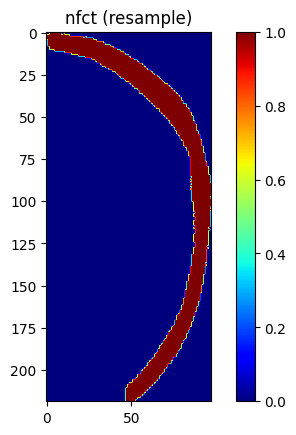

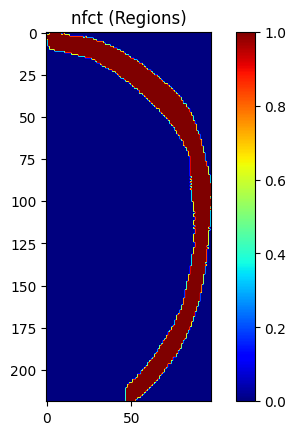

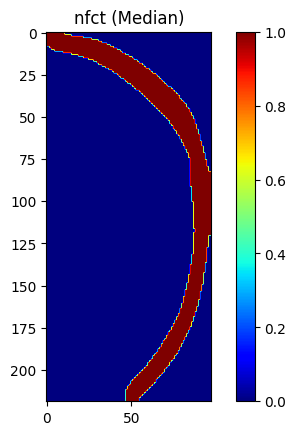

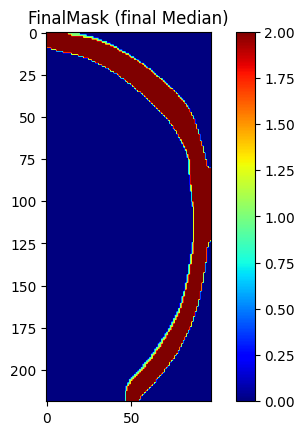

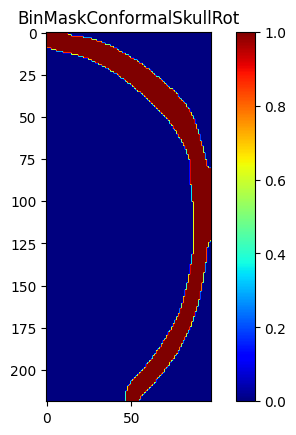

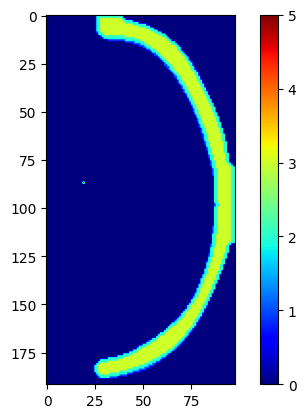

In [46]:
SimbNIBSDir = 'D:\Shirshak\Research\BabelBrain\Tests\CT_Test'
CTfile =SimbNIBSDir+os.sep+'CT_Phantom.nii.gz'
T1Conformal_nii = SimbNIBSDir+os.sep+'CT_Phantom_iso.nii.gz'
Mat4Trajectory = u'D:\Shirshak\Research\BabelBrain\Tests\CT_Test' +os.sep+'test.txt'

Frequency = 250e3
BasePPW = 6
CoregCT_MRI = 0
TrajectoryType = ''
nIterationsAlign = 10
InitialAligment = 'HF'
prefix = 'test'
HUThreshold = 300
from TranscranialModeling.BabelIntegrationBASE import GetSmallestSOS

SmallestSoS= GetSmallestSOS(Frequency,bShear=True)
SpatialStep=np.round(SmallestSoS/Frequency/BasePPW*1e3,3)
print('spatialStep', SpatialStep)

# traj = u'D:\Shirshak\Research\BabelBrain\Tests\SDrp42' +os.sep+'M1.txt'
mask = GetSkullMaskFromSimbNIBSSTLTest(SimbNIBSDir = SimbNIBSDir, 
                                       T1Conformal_nii=T1Conformal_nii,
                                       Mat4Trajectory=Mat4Trajectory,
                                       CT_or_ZTE_input=CTfile,
                                       CoregCT_MRI=CoregCT_MRI, TrajectoryType='',
                                       nIterationsAlign = nIterationsAlign, 
                                       Location=[0, 0, 0],DeviceName=VoxelizeCOMPUTING_BACKEND,bAlignToSkin=True, SpatialStep = SpatialStep, InitialAligment=InitialAligment,HUThreshold=HUThreshold,prefix=prefix)
# # mask = GetSkullMaskFromSimbNIBSSTLTest(SimbNIBSDir = simDir, T1Conformal_nii=simDir+os.sep+T1,Mat4Trajectory=traj,CT_or_ZTE_input=None,TrajectoryType='',DeviceName=VoxelizeCOMPUTING_BACKEND)
# # 0.789992 -0.418969 -0.447637 163.23 
# 0.357546 0.907911 -0.218766 128.229 
# 0.498071 0.0127726 0.867042 200 
# 0 0 0 1 

# mask = GetSkullMaskFromSimbNIBSSTLTest(SimbNIBSDir = simDir, T1Conformal_nii=simDir+os.sep+T1,Mat4Trajectory=traj,TrajectoryType='')

(0.735, 0.735, 0.735)

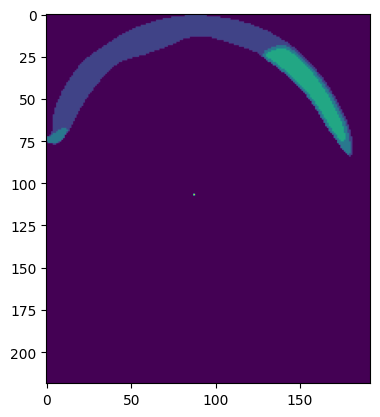

In [34]:
# simmask=nibabel.load(SimbNIBSDir+os.sep+'testBabelViscoInput.nii.gz')
# locTarget=np.where(simmask.get_fdata()==5)
# plt.imshow(simmask.get_fdata()[locTarget[0][0],:,:].T)
# simmask.header.get_zooms()

simmask=nibabel.load(SimbNIBSDir+os.sep+'testBabelViscoInput.nii.gz')
locTarget=np.where(simmask.get_fdata()==5)
plt.imshow(simmask.get_fdata()[:,:,locTarget[2][0]].T)
simmask.header.get_zooms()

In [45]:
def GetSkullMaskFromSimbNIBSSTLTest(SimbNIBSDir='4007/4007_keep/m2m_4007_keep/',
                                SimbNIBSType='charm',# indicate if processing was done with charm or headreco
                                T1Conformal_nii='4007/4007_keep/m2m_4007_keep/T1fs_conform.nii.gz', #be sure it is the conformal 
                                CT_or_ZTE_input=None,
                                bIsZTE = False,
                                CoregCT_MRI=0, #if using CT, 0 does not coreg (assuming this was done previously), 1 from CT to MRI
                                ZTERange=(0.1,0.6),
                                HUThreshold=300.0,
                                HUCapThreshold=2100.0,
                                CT_quantification=10, #bits
                                Mat4Trajectory=None, 
                                TrajectoryType='brainsight',                               
                                Foc=135.0, #Tx focal length
                                FocFOV=165.0, #Tx focal length used for FOV subvolume
                                TxDiam=157.0, # Tx aperture diameter used for FOV subvolume
                                Location=[27.5, -42, 42],#RAS location of target ,
                                TrabecularProportion=0.8, #proportion of trabecular bone
                                SpatialStep=1500/500e3/9*1e3, #step of mask to reconstruct , mm
                                prefix='', #Id to add to output file for identification
                                bDoNotAlign=False, #Use this to just move the Tx to match the coordinate with Tx facing S-->I, otherwise it will simulate the aligment of the Tx to be normal to the skull surface
                                nIterationsAlign=10, # number of iterations to align the tx, 10 is often way more than enough for shallow targets
                                InitialAligment='HF',
                                bPlot=True,
                                bAlignToSkin=False,
                                factorEnlargeRadius=1.05,
                                bApplyBOXFOV=False,
                                DeviceName=''): #created reduced FOV
    '''
    Generate masks for acoustic/viscoelastic simulations. 
    It creates an Nifti file that is in subject space using as main inputs the output files of the headreco tool and location of coordinates where focal point is desired
    
    
    ABOUT:
         author        - Samuel Pichardo
         date          - June 23, 2021
         last update   - Nov 27, 2021
    
    '''
    #load T1W
    T1Conformal=nibabel.load(T1Conformal_nii)
    baseaffine=T1Conformal.affine.copy()
    print('baseaffine',baseaffine)
    #sanity test to verify we have an isotropic scan
    assert(np.allclose(np.array(T1Conformal.header.get_zooms()),np.ones(3),rtol=1e-3))
        
    baseaffine[0,0]*=SpatialStep
    baseaffine[1,1]*=SpatialStep
    baseaffine[2,2]*=SpatialStep

    skull_stl=SimbNIBSDir+os.sep+'bone.stl' # Find another way to extract bone stl
    # csf_stl=SimbNIBSDir+os.sep+'csf.stl'
    # skin_stl=SimbNIBSDir+os.sep+'skin.stl'

    # Remove this part
    # if SimbNIBSType=='charm':

    #     #while charm is much more powerful to segment skull regions, we need to calculate the meshes ourselves
    #     charminput = SimbNIBSDir+os.sep+'final_tissues.nii.gz'
    #     charm= nibabel.load(charminput)
    #     charmdata=np.ascontiguousarray(charm.get_fdata())[:,:,:,0]
    #     AllTissueRegion=charmdata>0 #this mimics what the old headreco does for skin
    #     TMaskItk=sitk.ReadImage(charminput, sitk.sitkFloat32)>0 #we also kept an SITK Object

    #     BoneRegion=(charmdata>0) & (charmdata!=5) #this mimics what the old headreco does for bone
    #     CSFRegion=(charmdata==1) | (charmdata==2) | (charmdata==3) | (charmdata==9) #this mimics what the old headreco does for skin
    #     with CodeTimer("charm surface recon",unit='s'):
    #         skin_mesh=MaskToStl(AllTissueRegion,charm.affine)
    #         csf_mesh=MaskToStl(CSFRegion,charm.affine)
    #         skull_mesh=MaskToStl(BoneRegion,charm.affine)
    #         skin_mesh.export(skin_stl)
    #         csf_mesh.export(csf_stl)
    #         skull_mesh.export(skull_stl)
    # else:
    #     TMaskItk=sitk.ReadImage(SimbNIBSDir+os.sep+'skin.nii.gz', sitk.sitkFloat32)>0 #we also kept an SITK Object

    #building a cone object representing acoustic beam pointing to desired location
    # skull_stl = 'bone.stl'
    # print(SimbNIBSDir+os.sep+skull_stl)
    # print(os.path.isfile(SimbNIBSDir+os.sep+skull_stl))
    # if not os.path.isfile(SimbNIBSDir+os.sep+skull_stl):
    T1ConformalData = T1Conformal.get_fdata()
    sf=np.round((np.ones(3)*2)/T1Conformal.header.get_zooms()).astype(int)
    skullmask = ndimage.median_filter(T1ConformalData>HUThreshold,sf,mode='constant',cval=0)
    skull_mesh = MaskToStl(skullmask,T1Conformal.affine.copy())
    skull_mesh.export(skull_stl)
    # skull_stl=SimbNIBSDir+os.sep+skull_stl # Find another way to extract bone stl
    RadCone=TxDiam/2*factorEnlargeRadius
    if type(Foc) is tuple:
        Foc=Foc[0]
    HeightCone=np.sqrt(Foc**2-RadCone**2)
    print('HeightCone',HeightCone)
    
    InVAffine=np.linalg.inv(baseaffine)

    if TrajectoryType =='brainsight':
        print('*'*40+'\n Reading orientation and target location directly from Brainsight export\n'+'*'*40)
        RMat=ReadTrajectoryBrainsight(Mat4Trajectory)
        
    else:
        inMat=read_itk_affine_transform(Mat4Trajectory)
        # inMat = M1
         #we add this as in Brainsight the needle for trajectory starts at with a vector pointing 
         #to the feet direction , while in SlicerIGT it starts with a vector towards the head
        print('*'*40+'\n Reading orientation and target location directly from Slicer export\n'+'*'*40)
        # RMat = inMat
        RMat = itk_to_BSight(inMat)
    print('Trajectory (affine) Matrix\n',inMat)
    # tempRMat = RMat # Temp variable to store the matrix to use for simulation area
    print('Trajectory Matrix\n',RMat)
    Location=RMat[:3,3].tolist()
    print('Location',Location)
    #Ok maybe a bit too lacking of simplification..... 
    TransformationCone=np.eye(4)
    TransformationCone[2,2]=-1
    OrientVec=np.array([0,0,1]).reshape((1,3))
    TransformationCone[0,3]=Location[0]
    TransformationCone[1,3]=Location[1]
    TransformationCone[2,3]=Location[2]+HeightCone
    Cone=creation.cone(RadCone,HeightCone,transform=TransformationCone.copy())

    TransformationCone[2,3]=Location[2]
    CumulativeTransform=TransformationCone.copy() 
    
    TransformationCone=np.eye(4)
    TransformationCone[0,3]=-Location[0]
    TransformationCone[1,3]=-Location[1]
    TransformationCone[2,3]=-Location[2]

    CumulativeTransform=TransformationCone@CumulativeTransform

    Cone.apply_transform(TransformationCone)
    
    
    RMat=RMat[:3,:3]
    
    TransformationCone=np.eye(4)
    TransformationCone[0,3]=Location[0]
    TransformationCone[1,3]=Location[1]
    TransformationCone[2,3]=Location[2]
    
    TransformationCone[0:3,0:3]=RMat

    Cone.apply_transform(TransformationCone)

    CumulativeTransform=TransformationCone@CumulativeTransform

    print('Final RMAT')
    print(RMat)
    
    skull_mesh_cone=trimesh.util.concatenate([skull_mesh, Cone])
    skull_cone_stl=SimbNIBSDir+os.sep+'bone_cone.stl'
    skull_mesh_cone.export(skull_cone_stl)

    # Remove the skin and use the skull for the corners

    # skin_mesh = trimesh.load_mesh(skin_stl)
    skull_mesh = trimesh.load_mesh(skull_stl)
    skull_mesh =trimesh.boolean.intersection((skull_mesh,Cone),engine='blender')
    # temp_mesh = skull_mesh.copy()
    # tempRMat[0,2] *= 2
    # tempRMat[1,2] *= 2
    # tempRMat[1,2] *= 2
    # temp_mesh.apply_transform(tempRMat)
    # skull_mesh=trimesh.util.concatenate([skull_mesh, temp_mesh])
    # temp_mesh = skull_mesh.copy()
    #we intersect the skin region with a cone region oriented in the same direction as the acoustic beam
    # skin_mesh =trimesh.boolean.intersection((skin_mesh,Cone),engine='blender')
    # print('skull_mesh shape', skull_mesh.shape)
    #we obtain the list of Cartesian voxels inside the skin region intersected by the cone    
    with CodeTimer("voxelization ",unit='s'):
        if VoxelizeFilter is None:  
            # skin_grid = skin_mesh.voxelized(SpatialStep,max_iter=30).fill().points
            skull_grid = skull_mesh.voxelized(SpatialStep,max_iter=30).fill().points
        else:
            skull_grid = VoxelizeFilter(skull_mesh,targetResolution=SpatialStep*0.75,GPUBackend=VoxelizeCOMPUTING_BACKEND)

    # x_vec=np.arange(skin_grid[:,0].min(),skin_grid[:,0].max()+SpatialStep,SpatialStep)
    # y_vec=np.arange(skin_grid[:,1].min(),skin_grid[:,1].max()+SpatialStep,SpatialStep)
    # z_vec=np.arange(skin_grid[:,2].min(),skin_grid[:,2].max()+SpatialStep,SpatialStep)
    
    # x_vec=np.arange(skull_grid[:,0].min(),skull_grid[:,0].min()+1.5*HeightCone+SpatialStep,SpatialStep)
    # y_vec=np.arange(skull_grid[:,1].min(),skull_grid[:,1].min()+1.5*HeightCone+SpatialStep,SpatialStep)
    # z_vec=np.arange(skull_grid[:,2].min(),skull_grid[:,2].min()+1.5*HeightCone+SpatialStep,SpatialStep)
    
    x_vec=np.arange(skull_grid[:,0].min(),skull_grid[:,0].max()+2*(Location[0]-skull_grid[:,0].min())+SpatialStep,SpatialStep)
    y_vec=np.arange(skull_grid[:,1].min(),skull_grid[:,1].max()+2*(Location[1]-skull_grid[:,1].min())+SpatialStep,SpatialStep)
    z_vec=np.arange(skull_grid[:,2].min(),skull_grid[:,2].max()+2*(Location[2]-skull_grid[:,2].min())+SpatialStep,SpatialStep)
    
    # Change to add a arbitary corners for bounding box to account for no full skull
    Corner1=np.array([x_vec[0],y_vec[0],z_vec[0],1]).reshape((4,1))
    Corner2=np.array([x_vec[-1],y_vec[-1],z_vec[-1],1]).reshape((4,1))

    print('box size:', [2*(Location[0]-skull_grid[:,0].min()), 2*(Location[1]-skull_grid[:,1].min()), 2*(Location[2]-skull_grid[:,2].min())])
    print('Corner1: ', Corner1)
    print('Corner2: ',Corner2)

    #we will produce one dataset (used only for sanity tests)
    # with the same orientation as the T1 scan and just enclosing the list of points intersected
    AffIJKCorners=np.floor(np.dot(InVAffine,np.hstack((Corner1,Corner2)))).astype(int).T
    AffIJKCornersMin=np.min(AffIJKCorners,axis=0).reshape((4,1))
    NewOrig=np.dot(baseaffine,AffIJKCornersMin)
    
    baseaffine[:,3]=NewOrig.flatten()
    
    
    print('baseaffine',baseaffine)
    RMat4=np.eye(4)
    RMat4[:3,:3]=RMat*SpatialStep
    print('RMat4',RMat4)
   
    baseaffineRot=RMat4   
    
    
    print('baseaffineRot',baseaffineRot)
    
    InVAffine=np.linalg.inv(baseaffine)
    InVAffineRot=np.linalg.inv(baseaffineRot)
    
    XYZ=skull_grid # was using skin_grid
    #we make it a Nx4 array
    XYZ=np.hstack((XYZ,np.ones((XYZ.shape[0],1)))).T
    
    #now we prepare the new dataset that is perpendicular to the cone direction
    #first we calculate the indexes i,j,k
    AffIJK=np.round(np.dot(InVAffineRot,XYZ)).astype(int).T
    NewOrig=baseaffineRot @np.array([AffIJK[:,0].min(),AffIJK[:,1].min(),AffIJK[:,2].min(),1]).reshape((4,1))
    baseaffineRot[:,3]=NewOrig.flatten()
    InVAffineRot=np.linalg.inv(baseaffineRot)
    
    ALoc=np.ones((4,1))
    ALoc[:3,0]=np.array(Location)
    XYZ=np.hstack((XYZ,ALoc))
    AffIJK=np.round(np.dot(InVAffineRot,XYZ)).astype(int).T
    
    LocFocalPoint=AffIJK[-1,:3] #we recover the location in pixels of the intended target
    print('InVAffineRot', InVAffineRot)
    print('ALoc', ALoc)
    print('LocFocalPoint',LocFocalPoint)      
    ## This is the box that covers the minimal volume
    DimsBox=(np.max(AffIJK,axis=0)[:3]-np.min(AffIJK,axis=0)[:3]+1)*SpatialStep
    TransformationBox=np.eye(4)
    TransformationBox[2,3]=-DimsBox[2]/2
    TransformationBox[2,3]+=FocFOV-Foc
    
    BoxFOV=creation.box(DimsBox,
                        transform=TransformationBox)
    BoxFOV.apply_transform(CumulativeTransform)
    BoxFOV.export(os.path.dirname(T1Conformal_nii)+os.sep+prefix+'_box_FOV.stl')
      
    ##################### And we repeat and complete data extraction
    baseaffine=T1Conformal.affine.copy()
    baseaffine[0,0]*=SpatialStep
    baseaffine[1,1]*=SpatialStep
    baseaffine[2,2]*=SpatialStep

    # remove skin and csf
    skull_mesh = trimesh.load_mesh(skull_stl)
    # csf_mesh = trimesh.load_mesh(csf_stl)
    # skin_mesh = trimesh.load_mesh(skin_stl)  

    # remove skin and csf
    if bApplyBOXFOV:
        skull_mesh=trimesh.boolean.intersection((skull_mesh,BoxFOV),engine='blender')
        # csf_mesh  =trimesh.boolean.intersection((csf_mesh,  BoxFOV),engine='blender')
        # skin_mesh =trimesh.boolean.intersection((skin_mesh, BoxFOV),engine='blender')
    
    # remove skin and csf
    #we first substract to find the pure bone region
    if VoxelizeFilter is None:
        while(True):
            try:
                with CodeTimer("skull voxelization",unit='s'):
                    skull_grid = skull_mesh.voxelized(SpatialStep*0.75,max_iter=30).fill().points.astype(np.float32)
                # with CodeTimer("brain voxelization",unit='s'):
                    # csf_grid = csf_mesh.voxelized(SpatialStep*0.75,max_iter=30).fill().points.astype(np.float32)
                # with CodeTimer("skin voxelization",unit='s'):
                    # skin_grid = skin_mesh.voxelized(SpatialStep*0.75,max_iter=30).fill().points.astype(np.float32)
                break
            except AttributeError as err:
                print("Repeating CSG boolean since once in while it returns an scene instead of a mesh....")
                print(err)
            else:
                raise err
    else:
        with CodeTimer("skull voxelization",unit='s'):
            skull_grid = VoxelizeFilter(skull_mesh,targetResolution=SpatialStep*0.75,GPUBackend=VoxelizeCOMPUTING_BACKEND)
        # with CodeTimer("brain voxelization",unit='s'):
            # csf_grid = VoxelizeFilter(csf_mesh,targetResolution=SpatialStep*0.75,GPUBackend=VoxelizeCOMPUTING_BACKEND)
        # with CodeTimer("skin voxelization",unit='s'):
            # skin_grid = VoxelizeFilter(skin_mesh,targetResolution=SpatialStep*0.75,GPUBackend=VoxelizeCOMPUTING_BACKEND)
        
    # Testing. Remove later
    # print("skin_grid: " + str(skin_grid.shape))
    # print("skull_grid: " + str(skull_grid.shape))
    # print("csf_grid: " + str(csf_grid.shape))


    # Change to skull
    #we obtain the list of Cartesian voxels in the whole skin region intersected by the cone    
    # x_vec=np.arange(skull_grid[:,0].min(),skull_grid[:,0].max()+SpatialStep,SpatialStep)
    # y_vec=np.arange(skull_grid[:,1].min(),skull_grid[:,1].max()+SpatialStep,SpatialStep)
    # z_vec=np.arange(skull_grid[:,2].min(),skull_grid[:,2].max()+SpatialStep,SpatialStep)

    # x_vec=np.arange(skull_grid[:,0].min(),skull_grid[:,0].min()+1.5*HeightCone+SpatialStep,SpatialStep)
    # y_vec=np.arange(skull_grid[:,1].min(),skull_grid[:,1].min()+1.5*HeightCone+SpatialStep,SpatialStep)
    # z_vec=np.arange(skull_grid[:,2].min(),skull_grid[:,2].min()+1.5*HeightCone+SpatialStep,SpatialStep)

     #we obtain the list of Cartesian voxels in the whole skin region intersected by the cone    
    x_vec=np.arange(skull_grid[:,0].min(),skull_grid[:,0].max()+2*(Location[0]-skull_grid[:,0].min())+SpatialStep,SpatialStep)
    y_vec=np.arange(skull_grid[:,1].min(),skull_grid[:,1].max()+2*(Location[1]-skull_grid[:,1].min())+SpatialStep,SpatialStep)
    z_vec=np.arange(skull_grid[:,2].min(),skull_grid[:,2].max()+2*(Location[2]-skull_grid[:,2].min())+SpatialStep,SpatialStep)
    
    
    Corner1=np.array([x_vec[0],y_vec[0],z_vec[0],1]).reshape((4,1))
    Corner2=np.array([x_vec[-1],y_vec[-1],z_vec[-1],1]).reshape((4,1))

    #we will produce one dataset (used only for sanity tests)
    # with the same orientation as the T1 scan and just enclosing the list of points intersected
    AffIJKCorners=np.floor(np.dot(InVAffine,np.hstack((Corner1,Corner2)))).astype(int).T
    AffIJKCornersMin=np.min(AffIJKCorners,axis=0).reshape((4,1))
    NewOrig=np.dot(baseaffine,AffIJKCornersMin)
    
    baseaffine[:,3]=NewOrig.flatten()
    
    
    print('baseaffine',baseaffine)
    baseaffineRot=baseaffine.copy()
    RMat4=np.eye(4)
    RMat4[:3,:3]=RMat*SpatialStep
    print('RMat4',RMat4)
    
    
    baseaffineRot=RMat4
    
    print('baseaffineRot',baseaffineRot)
    
    InVAffine=np.linalg.inv(baseaffine)
    InVAffineRot=np.linalg.inv(baseaffineRot)
    InVAffineRot=InVAffineRot.astype(skull_grid.dtype)   # Changed from skin_grid 

    # with CodeTimer("skin masking",unit='s'):
    #     XYZ=skull_grid
    #     XYZ=np.hstack((XYZ,np.ones((XYZ.shape[0],1),dtype=skin_grid.dtype))).T
    #     #now we prepare the new dataset that is perpendicular to the cone direction
    #     AffIJK=np.round(np.dot(InVAffineRot,XYZ)).astype(np.int).T
    #     NewOrig=baseaffineRot @np.array([AffIJK[:,0].min(),AffIJK[:,1].min(),AffIJK[:,2].min(),1]).reshape((4,1))
    #     baseaffineRot[:,3]=NewOrig.flatten()
    #     InVAffineRot=np.linalg.inv(baseaffineRot)
    #     InVAffineRot=InVAffineRot.astype(skin_grid.dtype)
        # del AffIJK
    #     ALoc=np.ones((4,1),dtype=skin_grid.dtype)
    #     ALoc[:3,0]=np.array(Location,dtype=skin_grid.dtype)
    #     XYZ=np.hstack((XYZ,ALoc))
    #     AffIJK=np.round(np.dot(InVAffineRot,XYZ)).astype(np.int).T
        
    #     LocFocalPoint=AffIJK[-1,:3]
        
    # BinMaskConformalSkinRot=np.zeros(np.max(AffIJK,axis=0)[:3]+1,np.int8)
    #     BinMaskConformalSkinRot[AffIJK[:,0],AffIJK[:,1],AffIJK[:,2]]=1

    # del XYZ
    # del skin_grid
    # gc.collect()
    

    t0=time.time()
    with CodeTimer("skull masking",unit='s'):
        # XYZ=skull_grid
        XYZ=skull_grid
        XYZ=np.hstack((XYZ,np.ones((XYZ.shape[0],1),dtype=skull_grid.dtype))).T
        AffIJK=np.round(np.dot(InVAffineRot,XYZ)).astype(int).T
        NewOrig=baseaffineRot @np.array([AffIJK[:,0].min(),AffIJK[:,1].min(),AffIJK[:,2].min(),1]).reshape((4,1))
        baseaffineRot[:,3]=NewOrig.flatten()
        InVAffineRot=np.linalg.inv(baseaffineRot)
        InVAffineRot=InVAffineRot.astype(skull_grid.dtype)
        del AffIJK
        ALoc=np.ones((4,1),dtype=skull_grid.dtype)
        ALoc[:3,0]=np.array(Location,dtype=skull_grid.dtype)
        XYZ=np.hstack((XYZ,ALoc))
        AffIJK=np.round(np.dot(InVAffineRot,XYZ)).astype(int).T
        
        LocFocalPoint=AffIJK[-1,:3]
        BinMaskConformalSkullRot=np.zeros(np.max(AffIJK,axis=0)[:3]+1,np.int8)
        BinMaskConformalSkullRot[AffIJK[:,0],AffIJK[:,1],AffIJK[:,2]]=1
    del AffIJK
    del XYZ
    del skull_grid
    gc.collect()

    # with CodeTimer("csf masking",unit='s'):
    #     XYZ=csf_grid
    #     XYZ=np.hstack((XYZ,np.ones((XYZ.shape[0],1),dtype=csf_grid.dtype))).T
    #     AffIJK=np.round(np.dot(InVAffineRot,XYZ)).astype(np.int).T
    #     BinMaskConformalCSFRot=np.zeros(BinMaskConformalSkinRot.shape,np.uint8)
    #     inds=(AffIJK[:,0]<BinMaskConformalSkullRot.shape[0])&\
    #          (AffIJK[:,1]<BinMaskConformalSkullRot.shape[1])&\
    #          (AffIJK[:,2]<BinMaskConformalSkullRot.shape[2])
    #     AffIJK=AffIJK[inds,:]
    #     BinMaskConformalCSFRot[AffIJK[:,0],AffIJK[:,1],AffIJK[:,2]]=1
   
    # del AffIJK
    # del XYZ
    # del csf_grid
    # gc.collect()
    
    FinalMask=BinMaskConformalSkullRot

    # Now we deal if CT or ZTE has beegn given as input
    if CT_or_ZTE_input is  None:
        FinalMask[BinMaskConformalSkullRot==1]=2 #cortical
        # FinalMask[BinMaskConformalCSFRot==1]=0#brain
    else:
        if bIsZTE:
            print('Processing ZTE to pCT')
            with CodeTimer("Bias and coregistration ZTE to T1",unit='s'):
                rT1,rZTE=CTZTEProcessing.BiasCorrecAndCoreg(T1Conformal_nii,CT_or_ZTE_input,TMaskItk)
            with CodeTimer("Conversion ZTE to pCT",unit='s'):
                rCT = CTZTEProcessing.ConvertZTE_pCT(rT1,rZTE,TMaskItk,os.path.dirname(skull_stl),
                    ThresoldsZTEBone=ZTERange,SimbNIBSType=SimbNIBSType)
        else:
            with CodeTimer("Coregistration CT to T1",unit='s'):
                rCT=CTZTEProcessing.CTCorreg(T1Conformal_nii,CT_or_ZTE_input,CoregCT_MRI)
        rCTdata=rCT.get_fdata()
        hist = np.histogram(rCTdata[rCTdata>HUThreshold],bins=15)
        print('*'*40)
        print_hist(hist, title="CT HU", symbols=r"=",fg_colors="0",bg_colors="0",columns=80)
        rCTdata[rCTdata>HUCapThreshold]=HUCapThreshold
        sf=np.round((np.ones(3)*2)/rCT.header.get_zooms()).astype(int)
        sf2=np.round((np.ones(3)*5)/rCT.header.get_zooms()).astype(int)
        with CodeTimer("median filter CT",unit='s'):
            print('Theshold for bone',HUThreshold)
            if sys.platform in ['linux','win32']:
                gfct=cupy.asarray((rCTdata>HUThreshold))
                gfct=cndimage.median_filter(gfct,sf)
            else:
                fct=ndimage.median_filter(rCTdata>HUThreshold,sf,mode='constant',cval=0)
        
        with CodeTimer("binary closing CT",unit='s'):
            if sys.platform in ['linux','win32']:
                gfct=cndimage.binary_closing(gfct,structure=cupy.ones(sf2,dtype=int))
                fct=gfct.get()
            else:
                fct=ndimage.binary_closing(fct,structure=np.ones(sf2,dtype=int))
        fct=nibabel.Nifti1Image(fct.astype(np.float32), affine=rCT.affine)
        print('fct', fct.get_fdata().shape)
        mask_nifti2 = nibabel.Nifti1Image(FinalMask, affine=baseaffineRot)
        print('mask_nifti2', mask_nifti2.get_fdata().shape)

        with CodeTimer("median filter CT mask extrapol",unit='s'):
            nfct=processing.resample_from_to(fct,mask_nifti2,mode='constant',cval=0)
       
        nfct=np.ascontiguousarray(nfct.get_fdata())>0.5

        # nfct = nfct.get_fdata()
        print('nfct', nfct.shape)
        if bPlot:
                plt.figure()
                plt.imshow(nfct[LocFocalPoint[0],:,:],cmap=plt.cm.jet)
                plt.title('nfct (resample)')
                plt.gca().set_aspect(1.0)
                plt.colorbar()
        ##We will create an smooth surface
        with CodeTimer("skull surface CT",unit='s'):
            label_img=label(nfct)
            print('label_img',len(label_img))
            regions= regionprops(label_img)
            print('regions',len(regions))
            regions=sorted(regions,key=lambda d: d.area)
            print(len(regions))
            nfct=label_img==regions[-1].label
            if bPlot:
                plt.figure()
                plt.imshow(nfct[LocFocalPoint[0],:,:],cmap=plt.cm.jet)
                plt.title('nfct (Regions)')
                plt.gca().set_aspect(1.0)
                plt.colorbar()
            smct=MaskToStl(nfct,baseaffineRot)
        # with CodeTimer("CT skull voxelization",unit='s'):
        #     if VoxelizeFilter is None:
        #         ct_grid = smct.voxelized(SpatialStep*0.75,max_iter=30).fill().points.astype(np.float32)
        #     else:
        #         ct_grid=VoxelizeFilter(smct,targetResolution=SpatialStep*0.75,GPUBackend=VoxelizeCOMPUTING_BACKEND)
        
        # XYZ=ct_grid
        # XYZ=np.hstack((XYZ,np.ones((XYZ.shape[0],1),dtype=ct_grid.dtype))).T
        # AffIJK=np.round(np.dot(InVAffineRot,XYZ)).astype(int).T

        # nfct=np.zeros_like(FinalMask)

        # inds=(AffIJK[:,0]<nfct.shape[0])&\
        #      (AffIJK[:,1]<nfct.shape[1])&\
        #      (AffIJK[:,2]<nfct.shape[2])
        # AffIJK=AffIJK[inds,:]

        # nfct[AffIJK[:,0],AffIJK[:,1],AffIJK[:,2]]=1

        with CodeTimer("CT median filter",unit='s'):
            if sys.platform in ['linux','win32']:
                gnfct=cupy.asarray(nfct.astype(np.uint8))
                gnfct=cndimage.median_filter(gnfct,7)
                nfct=gnfct.get()
            else:
                if MedianFilter is None:
                    nfct=ndimage.median_filter(nfct.astype(np.uint8),7)
                else:
                    nfct=MedianFilter(nfct.astype(np.uint8),GPUBackend=MedianCOMPUTING_BACKEND)
            nfct=nfct!=0

        # del XYZ
        # del ct_grid
        if bPlot:
            plt.figure()
            plt.imshow(nfct[LocFocalPoint[0],:,:],cmap=plt.cm.jet)
            plt.title('nfct (Median)')
            plt.gca().set_aspect(1.0)
            plt.colorbar()

        ############
        with CodeTimer("CT extrapol",unit='s'):
            print('rCTdata range',rCTdata.min(),rCTdata.max())
            rCT = nibabel.Nifti1Image(rCTdata, rCT.affine, rCT.header)
            nCT=processing.resample_from_to(rCT,mask_nifti2,mode='constant',cval=rCTdata.min())
            ndataCT=np.ascontiguousarray(nCT.get_fdata()).astype(np.float32)
            ndataCT[ndataCT>HUCapThreshold]=HUCapThreshold
            print('ndataCT range',ndataCT.min(),ndataCT.max())
            ndataCT[nfct==False]=0

        # with CodeTimer("CT binary_dilation",unit='s'):
        #     BinMaskConformalCSFRot= ndimage.binary_dilation(BinMaskConformalCSFRot,iterations=6)
        # with CodeTimer("FinalMask[BinMaskConformalCSFRot]=4",unit='s'):
        #     FinalMask[BinMaskConformalCSFRot]=4  
        #brain
        with CodeTimer("FinalMask[nfct]=2",unit='s'):
            FinalMask[nfct]=2  #bone
        #we do a cleanup of islands 
        # with CodeTimer("Labeling",unit='s'):
        #     label_img = label(FinalMask==1)
          
        # with CodeTimer("regionprops",unit='s'):
        #     regions= regionprops(label_img)

        # print("number of skin region islands", len(regions))
        # regions=sorted(regions,key=lambda d: d.area)
        # for l in regions[:-1]:
        #     FinalMask[label_img==l.label]=4

        CTBone=ndataCT[nfct]
        CTBone[CTBone<HUThreshold]=HUThreshold #we cut off to avoid problems in acoustic sim
        ndataCT[nfct]=CTBone
        maxData=ndataCT[nfct].max()
        minData=ndataCT[nfct].min()
        
        A=maxData-minData
        M = 2**CT_quantification-1
        ResStep=A/M 
        qx = ResStep *  np.round( (M/A) * (ndataCT[nfct]-minData) )+ minData
        ndataCT[nfct]=qx
        UniqueHU=np.unique(ndataCT[nfct])
        print('Unique CT values',len(UniqueHU))
        np.savez_compressed(os.path.dirname(T1Conformal_nii)+os.sep+prefix+'CT-cal',UniqueHU=UniqueHU)
        with CodeTimer("Mapping unique values",unit='s'):
            if MapFilter is None:
                ndataCTMap=np.zeros(ndataCT.shape,np.uint32)
                for n,d in enumerate(UniqueHU):
                    ndataCTMap[ndataCT==d]=n
                ndataCTMap[nfct==False]=0
            else:
                ndataCTMap=MapFilter(ndataCT,nfct.astype(np.uint8),UniqueHU,GPUBackend=MapFilterCOMPUTING_BACKEND)

        nCT=nibabel.Nifti1Image(ndataCTMap, nCT.affine, nCT.header)
        outname=os.path.dirname(T1Conformal_nii)+os.sep+prefix+'CT.nii.gz'
        nCT.to_filename(outname)
        outname=os.path.dirname(T1Conformal_nii)+os.sep+prefix+'CT_smooth.stl'
        smct.export(outname)

    with CodeTimer("final median filter ",unit='s'):
        if sys.platform in ['linux','win32']:
            gFinalMask=cupy.asarray(FinalMask.astype(np.uint8))
            gFinalMask=cndimage.median_filter(gFinalMask,7)
            FinalMask=gFinalMask.get()
        else:
            if MedianFilter is None:
                FinalMask=ndimage.median_filter(FinalMask.astype(np.uint8),7)
            else:
                FinalMask=MedianFilter(FinalMask.astype(np.uint8),GPUBackend=MedianCOMPUTING_BACKEND)
    if bPlot:
        plt.figure()
        plt.imshow(FinalMask[LocFocalPoint[0],:,:],cmap=plt.cm.jet)
        plt.title('FinalMask (final Median)')
        plt.gca().set_aspect(1.0)
        plt.colorbar()
    #we extract back the bone part
    BinMaskConformalSkullRot=FinalMask==2
    if bPlot:
        plt.figure()
        plt.imshow(BinMaskConformalSkullRot[LocFocalPoint[0],:,:],cmap=plt.cm.jet)
        plt.title('BinMaskConformalSkullRot')
        plt.gca().set_aspect(1.0)
        plt.colorbar()
    LineViewBone=BinMaskConformalSkullRot[LocFocalPoint[0],LocFocalPoint[1],LocFocalPoint[2]:]
    DegreeErosion=int((LineViewBone.sum()*(1-TrabecularProportion)))
    print('DegreeErosion',DegreeErosion)
    Trabecula=ndimage.binary_erosion(BinMaskConformalSkullRot,iterations=DegreeErosion)
    #we erode to establish the section of bone associated with trabecular
    FinalMask[Trabecula]=3 #trabecula
    
    FinalMask[LocFocalPoint[0],LocFocalPoint[1],LocFocalPoint[2]]=5 #focal point location
    print('Local Focal Point', [LocFocalPoint[0],LocFocalPoint[1],LocFocalPoint[2]])
    mask_nifti2 = nibabel.Nifti1Image(FinalMask, affine=baseaffineRot)

    outname=os.path.dirname(T1Conformal_nii)+os.sep+prefix+'BabelViscoInput.nii.gz'
    mask_nifti2.to_filename(outname)

    with CodeTimer("resampling T1 to mask",unit='s'):
        T1Conformal=processing.resample_from_to(T1Conformal,mask_nifti2,mode='constant',order=0,cval=T1Conformal.get_fdata().min())
        T1W_resampled_fname=os.path.dirname(T1Conformal_nii)+os.sep+prefix+'T1W_Resampled.nii.gz'
        T1Conformal.to_filename(T1W_resampled_fname)
    
    if bPlot:
        plt.figure()
        plt.imshow(FinalMask[:,LocFocalPoint[1],:],cmap=plt.cm.jet)
        plt.gca().set_aspect(1.0)
        plt.colorbar()
    
    return FinalMask 


(array([172], dtype=int64), array([60], dtype=int64), array([50], dtype=int64))

Target [63.94500124454498, 78.64500153064728, 13.96500027179718]


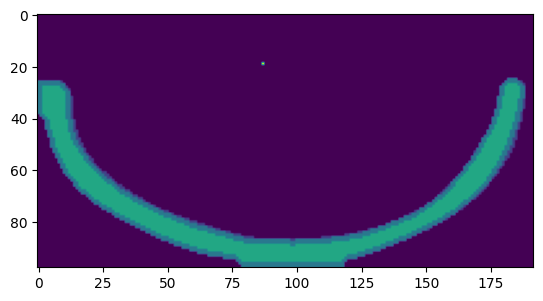

In [165]:
simmask=nibabel.load(SimbNIBSDir+os.sep+'testBabelViscoInput.nii.gz')
locTarget=np.where(simmask.get_fdata()==5)
plt.imshow(simmask.get_fdata()[:,locTarget[1][0],:].T)
simmask.header.get_zooms()
print('Target', [zooms[0]*locTarget[0][0], zooms[1]*locTarget[1][0], zooms[2]*locTarget[2][0]])

In [137]:
SimbNIBSDir = u'D:/Shirshak/Research/BabelBrain/Tests/SDrp42/m2m_SDR_0p42'
CTDir =u'D:/Shirshak/Research/BabelBrain/Tests/SDrp42/CT.nii.gz'
T1Conformal_nii = u'D:/Shirshak/Research/BabelBrain/Tests/SDrp42/T1W.nii.gz'
Mat4Trajectory = u'D:/Shirshak/Research/BabelBrain/Tests/SDrp42/M1.txt'
Frequency = 500e3
BasePPW = 6
CoregCT_MRI = 0
TrajectoryType = ''
nIterationsAlign = 10
InitialAligment = 'HF'
prefix = 'test'
HUThreshold = 300
from TranscranialModeling.BabelIntegrationBASE import GetSmallestSOS

SmallestSoS= GetSmallestSOS(Frequency,bShear=True)
SpatialStep=np.round(SmallestSoS/Frequency/BasePPW*1e3,3)
print('spatialStep', SpatialStep)
# traj = u'D:\Shirshak\Research\BabelBrain\Tests\SDrp42' +os.sep+'M1.txt'
mask = GetSkullMaskFromSimbNIBSSTL_MainTest(SimbNIBSDir = SimbNIBSDir, T1Conformal_nii=T1Conformal_nii,Mat4Trajectory=Mat4Trajectory,CT_or_ZTE_input=CTDir,CoregCT_MRI=CoregCT_MRI, TrajectoryType='',nIterationsAlign = nIterationsAlign, Location=[0, 0, 0],DeviceName=VoxelizeCOMPUTING_BACKEND,bAlignToSkin=True, SpatialStep = SpatialStep, InitialAligment=InitialAligment,prefix=prefix, HUThreshold=HUThreshold)

GetSmallestSOS 1102.5149999999999
spatialStep 0.368
baseaffine [[ 9.98356521e-01  2.24578101e-02 -5.23192100e-02 -8.50920029e+01]
 [-2.05011293e-02  9.99081373e-01  3.76317091e-02 -1.33979095e+02]
 [ 5.31151295e-02 -3.64980102e-02  9.97921109e-01 -5.82964211e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Code block 'charm surface recon' took: 8.26880 s
HeightCone 106.91641302905742
****************************************
 Reading orientation and target location directly from Slicer export
****************************************
Trajectory Matrix
 [[-7.29077071e-01  7.73008576e-02 -6.80052353e-01 -2.55750101e+01]
 [ 4.22402025e-02  9.96789453e-01  6.80187581e-02 -1.29308739e+01]
 [-6.83126921e-01 -2.08653678e-02  7.30001538e-01  1.10525004e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Location [-25.575010125903535, -12.930873893197328, 110.52500393494121]
Final RMAT
[[-0.72907707  0.07730086 -0.68005235]
 [ 0.0422402   0.99678945  0

zooms (0.735, 0.735, 0.735)
Elastic Solution Shape (192, 205, 96)
Target [87, 107, 19]
Target (mm) [63.94500124454498, 78.64500153064728, 13.96500027179718]


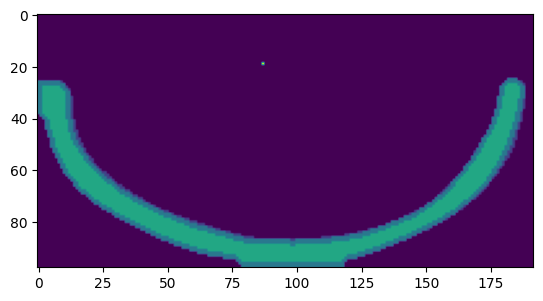

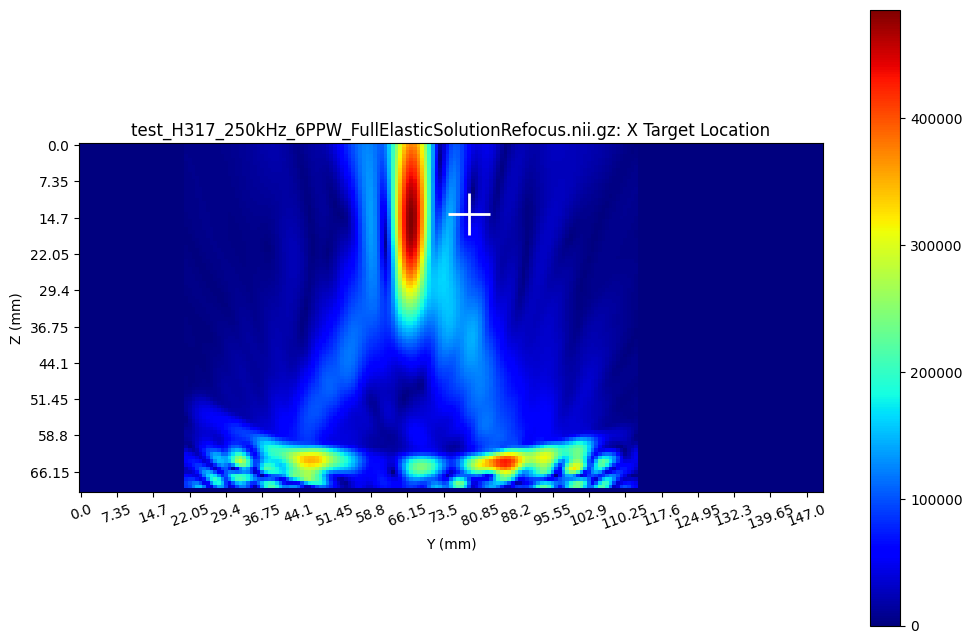

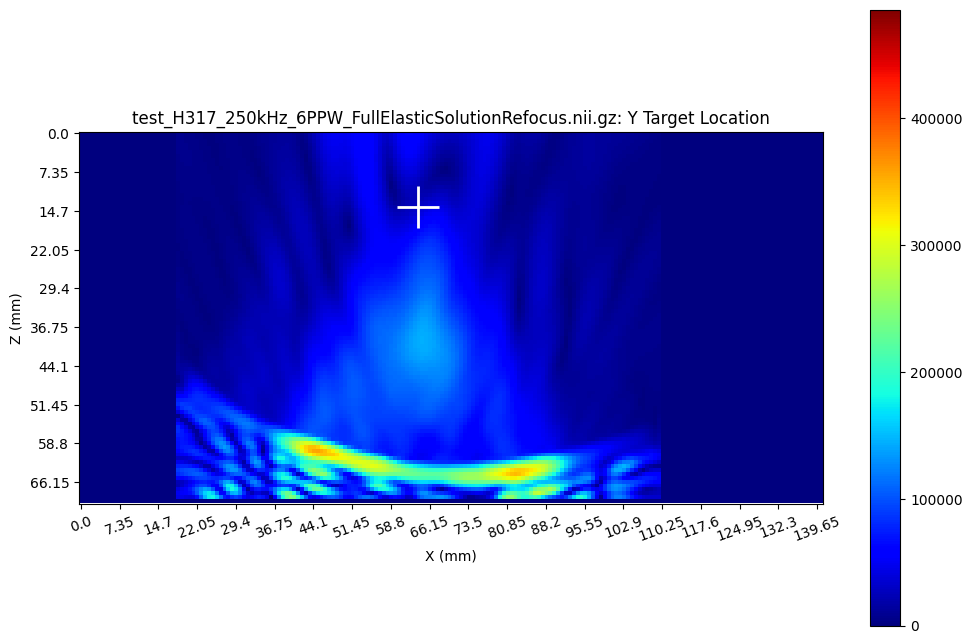

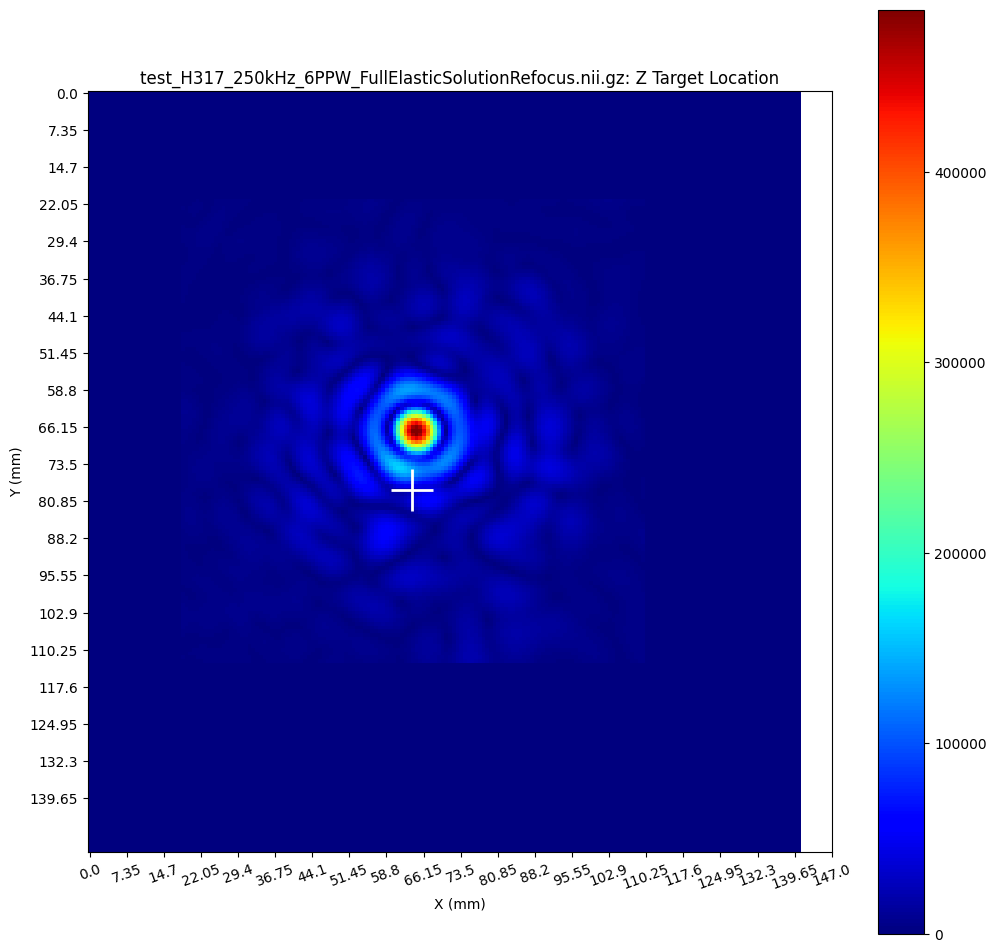

In [210]:
# filename = u'test_H317_250kHz_6PPW_FullElasticSolution.nii.gz'
filename = u'test_H317_250kHz_6PPW_FullElasticSolutionRefocus.nii.gz'
elasticSolution = u'D:\Shirshak\Research\BabelBrain\Tests\CT_Test' + os.sep +filename
elasticSolutionImg=nibabel.load(elasticSolution)
simmask=nibabel.load(SimbNIBSDir+os.sep+'testBabelViscoInput.nii.gz')
zooms = simmask.header.get_zooms()
print('zooms', zooms)
locTarget=np.where(simmask.get_fdata()==5)
print('Elastic Solution Shape', elasticSolutionImg.get_fdata().shape)
# default_x_ticks = np.linspace(0,elasticSolutionImg.get_fdata().shape, elasticSolutionImg.get_fdata().shape[0]/10)
# print(default_x_ticks)
simmask=nibabel.load(SimbNIBSDir+os.sep+'testBabelViscoInput.nii.gz')
locTarget=np.where(simmask.get_fdata()==5)
plt.imshow(simmask.get_fdata()[:,locTarget[1][0],:].T)
simmask.header.get_zooms()
print('Target', [locTarget[0][0], locTarget[1][0], locTarget[2][0]])
print('Target (mm)', [zooms[0]*locTarget[0][0], zooms[1]*locTarget[1][0], zooms[2]*locTarget[2][0]])

elasticData = elasticSolutionImg.get_fdata()
elasticData[:,:,elasticData.shape[2]-1]= 0

plt.figure(figsize= (12,8))
slice= elasticData[locTarget[0][0],:,:].T
# slice/=slice.max()
plt.imshow(slice,cmap=plt.cm.jet)
plt.plot(locTarget[1], locTarget[2],'w+', mew=2, ms=30)
plt.title(filename + ': X Target Location')
locs=np.arange(0,elasticData.shape[1],step=10)
values=np.round(np.arange(0,elasticData.shape[1],step=10)*zooms[1],2)
plt.xticks(locs,values,rotation=20)
locs=np.arange(0,elasticData.shape[2],step=10)
values=np.round(np.arange(0,elasticData.shape[2],step=10)*zooms[2],2)
vmin, vmax = plt.gci().get_clim()
plt.yticks(locs,values)
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
plt.gca().set_aspect(1.0)
plt.colorbar()

plt.figure(figsize= (12,8))
slice= elasticData[:,locTarget[1][0],:].T
# slice/=slice.max()
plt.imshow(slice,cmap=plt.cm.jet, vmin=vmin,vmax=vmax)
plt.plot(locTarget[0], locTarget[2],'w+', mew=2, ms=30)
plt.title(filename + ': Y Target Location')
locs=np.arange(0,elasticSolutionImg.get_fdata().shape[0],step=10)
values=np.round(np.arange(0,elasticSolutionImg.get_fdata().shape[0],step=10)*zooms[0],2)
plt.xticks(locs,values,rotation=20)
locs=np.arange(0,elasticSolutionImg.get_fdata().shape[2],step=10)
values=np.round(np.arange(0,elasticSolutionImg.get_fdata().shape[2],step=10)*zooms[2],2)
plt.yticks(locs,values)
plt.xlabel('X (mm)')
plt.ylabel('Z (mm)')
plt.gca().set_aspect(1.0)
plt.colorbar()

plt.figure(figsize= (12,12))
slice= elasticData[:,:,locTarget[2][0]].T
# slice/=slice.max()
plt.imshow(slice,cmap=plt.cm.jet, vmin=vmin, vmax=vmax)
plt.plot(locTarget[0], locTarget[1],'w+',mew=2, ms=30)
plt.title(filename + ': Z Target Location')
locs=np.arange(0,elasticSolutionImg.get_fdata().shape[1],step=10)
values=np.round(np.arange(0,elasticSolutionImg.get_fdata().shape[1],step=10)*zooms[1],2)
plt.xticks(locs,values,rotation=20)
locs=np.arange(0,elasticSolutionImg.get_fdata().shape[0],step=10)
values=np.round(np.arange(0,elasticSolutionImg.get_fdata().shape[0],step=10)*zooms[0],2)
plt.yticks(locs,values)
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.gca().set_aspect(1.0)
plt.colorbar()

Elastic Solution Shape (192, 205, 96)


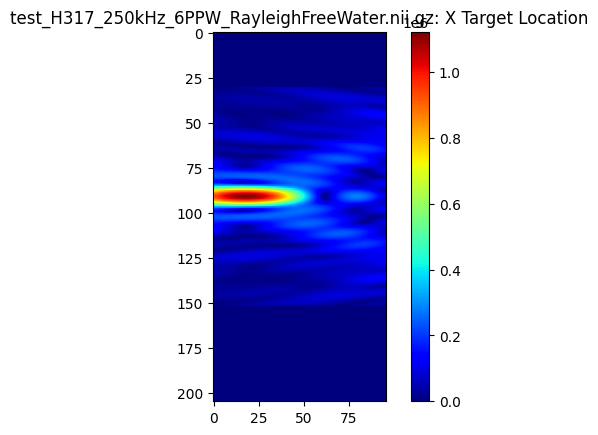

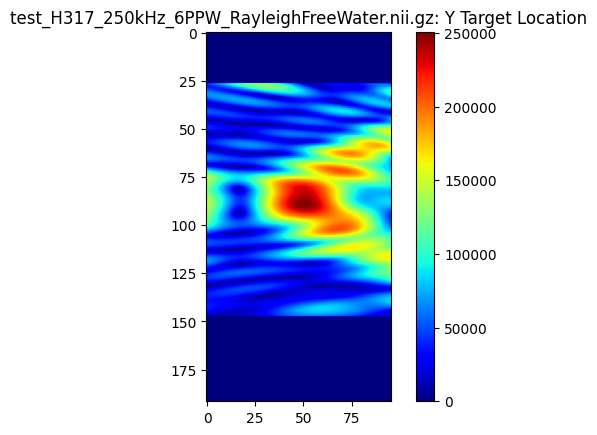

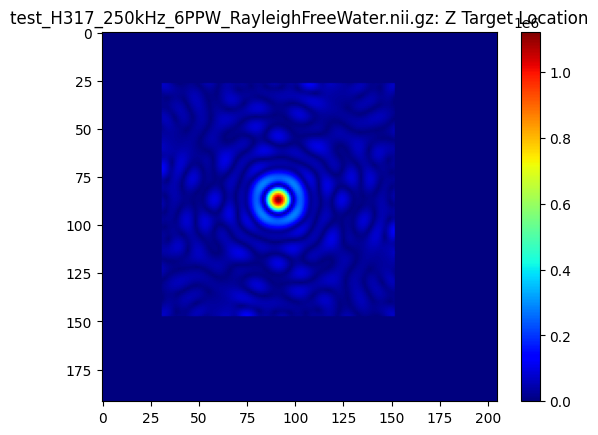

In [57]:
filename = u'test_H317_250kHz_6PPW_RayleighFreeWater.nii.gz'
elasticSolution = u'D:\Shirshak\Research\BabelBrain\Tests\CT_Test' + os.sep +filename
elasticSolutionImg=nibabel.load(elasticSolution)
simmask=nibabel.load(SimbNIBSDir+os.sep+'testBabelViscoInput.nii.gz')
locTarget=np.where(simmask.get_fdata()==5)
print('Elastic Solution Shape', elasticSolutionImg.get_fdata().shape)


plt.figure()
plt.imshow(elasticSolutionImg.get_fdata()[locTarget[0][0],:,:],cmap=plt.cm.jet)
plt.title(filename + ': X Target Location')
plt.gca().set_aspect(1.0)
plt.colorbar()

plt.figure()
plt.imshow(elasticSolutionImg.get_fdata()[:,locTarget[1][0],:],cmap=plt.cm.jet)
plt.title(filename + ': Y Target Location')
plt.gca().set_aspect(1.0)
plt.colorbar()


plt.figure()
plt.imshow(elasticSolutionImg.get_fdata()[:,:,locTarget[2][0]],cmap=plt.cm.jet)
plt.title(filename + ': Z Target Location')
plt.gca().set_aspect(1.0)
plt.colorbar()

Elastic Solution Shape (192, 205, 96)


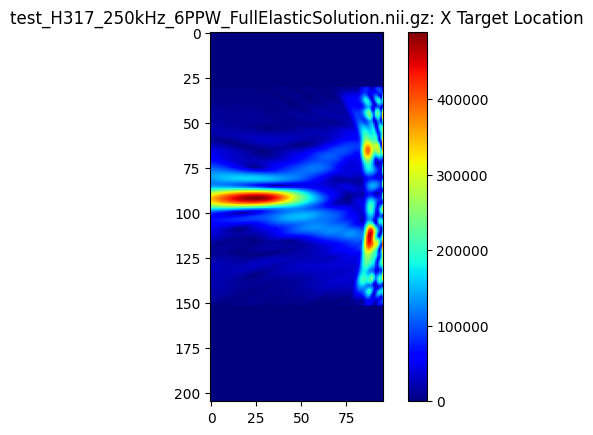

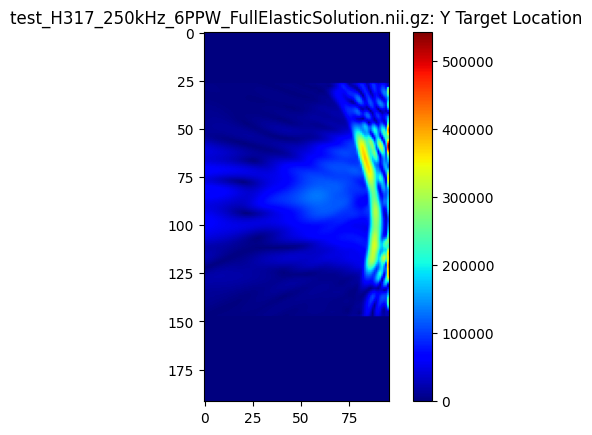

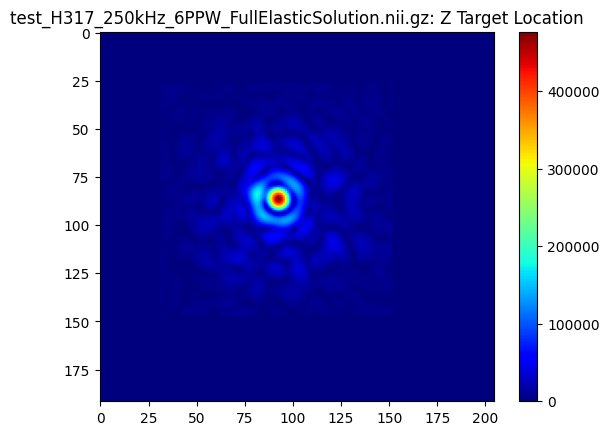

In [59]:
filename = u'test_H317_250kHz_6PPW_FullElasticSolution.nii.gz'
elasticSolution = u'D:\Shirshak\Research\BabelBrain\Tests\CT_Test' + os.sep +filename
elasticSolutionImg=nibabel.load(elasticSolution)
simmask=nibabel.load(SimbNIBSDir+os.sep+'testBabelViscoInput.nii.gz')
locTarget=np.where(simmask.get_fdata()==5)
print('Elastic Solution Shape', elasticSolutionImg.get_fdata().shape)


plt.figure()
plt.imshow(elasticSolutionImg.get_fdata()[locTarget[0][0],:,:],cmap=plt.cm.jet)
plt.title(filename + ': X Target Location')
plt.gca().set_aspect(1.0)
plt.colorbar()

plt.figure()
plt.imshow(elasticSolutionImg.get_fdata()[:,locTarget[1][0],:],cmap=plt.cm.jet)
plt.title(filename + ': Y Target Location')
plt.gca().set_aspect(1.0)
plt.colorbar()


plt.figure()
plt.imshow(elasticSolutionImg.get_fdata()[:,:,locTarget[2][0]],cmap=plt.cm.jet)
plt.title(filename + ': Z Target Location')
plt.gca().set_aspect(1.0)
plt.colorbar()

In [77]:
Waterh5 = u'test_H317_250kHz_6PPW_Water_DataForSim.h5'
Skullh5 = u'test_H317_250kHz_6PPW_DataForSim.h5'
Water=ReadFromH5py(SimbNIBSDir+os.sep+Waterh5)
Skull=ReadFromH5py(SimbNIBSDir+os.sep+Skullh5)
print('keys', Skull.keys())
# print(Skull['BasePhasedArrayProgramming'])
print((360*2.5e5*Skull['BasePhasedArrayProgrammingRefocusing'].real)%360)
print((360*2.5e5*Skull['BasePhasedArrayProgramming'][0].real))

keys dict_keys(['AdjustmentInRAS', 'BasePhasedArrayProgramming', 'BasePhasedArrayProgrammingRefocusing', 'DistanceConeToFocus', 'DistanceFromSkin', 'Material', 'MaterialMap', 'MaterialMapCT', 'RotationZ', 'SpatialStep', 'TargetLocation', 'TxMechanicalAdjustmentX', 'TxMechanicalAdjustmentY', 'TxMechanicalAdjustmentZ', 'XSteering', 'YSteering', 'ZSteering', 'affine', 'bDoRefocusing', 'p_amp', 'p_amp_refocus', 'x_vec', 'y_vec', 'z_vec'])
[277.7096    183.92871   226.35645     6.4853516 238.23096    16.361328
 205.16406   104.19531    19.492188   17.507812  108.10156    91.19141
 343.70703   113.76172   234.10352    11.06897   189.97656   285.9619
 217.66797   194.80664   226.00781   208.71094   313.4414    138.97656
 170.21875   245.3164    183.7299     68.36621   320.20898   274.7251
 320.49023   354.90875   122.898926  246.99683   305.92285   118.02246
 181.29492    67.148926  180.50098   205.85791    91.046875   48.213867
 185.13672   251.07227   227.15234   341.8125    182.28125   128

[62 62 79]
****************************************
****************************************
Correction Factor for Isppa 60687.37645397606 
****************************************
****************************************

slice [0.02703582 0.01544193 0.03599856 0.14570422 0.28987218 0.36844302
 0.33089059 0.21414983 0.09492158 0.02291734 0.00255676 0.02210174
 0.08515477 0.2114279  0.40654368 0.62652154 0.77522723 0.75698231
 0.55634994 0.27437078 0.0735452  0.06444853 0.22563452 0.42310202
 0.51143344 0.43628905 0.26587968 0.13783023 0.16491205 0.36198232
 0.63727657 0.85272595 0.91625214 0.83837122 0.70136462 0.57164334
 0.4513534  0.3165095  0.1732371  0.06077899 0.00763403 0.00128738
 0.00374625 0.00361652 0.02038839 0.07647939 0.16958306 0.26306885
 0.30525142 0.26634204 0.16657203 0.07258488 0.0566242  0.1423335
 0.27854133 0.36987717 0.34917742 0.23476379 0.11857376 0.08851285
 0.15186004 0.23194692 0.09124574 0.1638942  0.06149337 0.02029233
 0.08167018 0.19209747 0.26274243 0

15

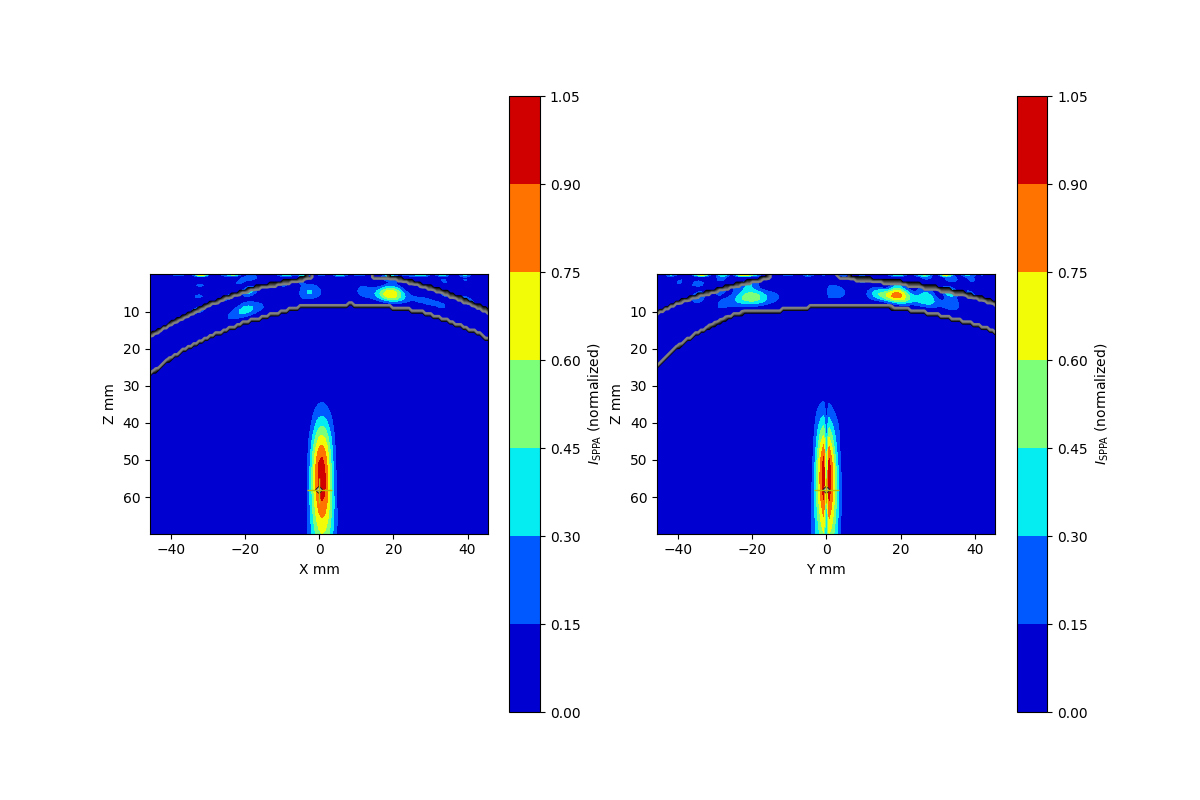

In [75]:
import ipywidgets as wdg  # Using the ipython notebook widgets
%matplotlib widget
SimbNIBSDir = 'D:\Shirshak\Research\BabelBrain\Tests\CT_Test'
Waterh5 = u'test_H317_250kHz_6PPW_Water_DataForSim.h5'
Skullh5 = u'test_H317_250kHz_6PPW_DataForSim.h5'
Water=ReadFromH5py(SimbNIBSDir+os.sep+Waterh5)
Skull=ReadFromH5py(SimbNIBSDir+os.sep+Skullh5)

# if self._MainApp._bInUseWithBrainsight:
#     if Skull['bDoRefocusing']:
#         #we update the name to be loaded in BSight
#         self._MainApp._BrainsightInput=self._MainApp._prefix_path+'FullElasticSolutionRefocus.nii.gz'
#     with open(self._MainApp._BrainsightSyncPath+os.sep+'Output.txt','w') as f:
#         f.write(self._MainApp._BrainsightInput) 
# self._MainApp.ExportTrajectory(CorX=Skull['AdjustmentInRAS'][0],
#                             CorY=Skull['AdjustmentInRAS'][1],
#                             CorZ=Skull['AdjustmentInRAS'][2])

LocTarget=Skull['TargetLocation']
print(LocTarget)

if Skull['bDoRefocusing']:
    SelP='p_amp_refocus'
else:
    SelP='p_amp'

for d in [Skull]:
    for t in [SelP,'MaterialMap']:
        d[t]=np.ascontiguousarray(np.flip(d[t],axis=2))

for d in [Water]:
    for t in ['p_amp','MaterialMap']:
        d[t]=np.ascontiguousarray(np.flip(d[t],axis=2))

DistanceToTarget=58.07

Water['z_vec']*=1e3
Skull['z_vec']*=1e3
Skull['x_vec']*=1e3
Skull['y_vec']*=1e3
Skull['MaterialMap'][Skull['MaterialMap']==3]=2
Skull['MaterialMap'][Skull['MaterialMap']==4]=3


IWater=Water['p_amp']**2/2/Water['Material'][0,0]/Water['Material'][0,1]

DensityMap=Skull['Material'][:,0][Skull['MaterialMap']]
SoSMap=    Skull['Material'][:,1][Skull['MaterialMap']]
ISkull=Skull[SelP]**2/2/DensityMap/SoSMap/1e4

IntWaterLocation=IWater[LocTarget[0],LocTarget[1],LocTarget[2]]
IntSkullLocation=ISkull[LocTarget[0],LocTarget[1],LocTarget[2]]

EnergyAtFocusWater=IWater[:,:,LocTarget[2]].sum()
EnergyAtFocusSkull=ISkull[:,:,LocTarget[2]].sum()

ISkull/=ISkull[Skull['MaterialMap']==3].max()
IWater/=IWater[Skull['MaterialMap']==3].max()

Factor=EnergyAtFocusWater/EnergyAtFocusSkull
print('*'*40+'\n'+'*'*40+'\n'+'Correction Factor for Isppa',Factor,'\n'+'*'*40+'\n'+'*'*40+'\n')



# static_ax1,static_ax2 = static_canvas.figure.subplots(1,2)
f, (static_ax1, static_ax2) = plt.subplots(1, 2,figsize=(12,8))
# plt.figure(figsize=(12,12))
# static_ax2 = plt.gca()
dz=np.diff(Skull['z_vec']).mean()
Zvec=Skull['z_vec'].copy()
Zvec-=Zvec[LocTarget[2]]
Zvec+=DistanceToTarget#+self.Widget.ZSteeringSpinBox.value()
XX,ZZ=np.meshgrid(Skull['x_vec'],Zvec)
slice1 = ISkull[:,LocTarget[1],:]
slice1/=slice1.max()
print('slice',slice.T[0,:])
# self._imContourf1=static_ax1.contourf(XX,ZZ,slice.T,np.arange(2,22,2)/20,cmap=plt.cm.jet)
_imContourf1=static_ax1.contourf(XX,ZZ,slice1.T,cmap=plt.cm.jet)
h=plt.colorbar(_imContourf1,ax=static_ax1)
h.set_label('$I_{\mathrm{SPPA}}$ (normalized)')
static_ax1.contour(XX,ZZ,Skull['MaterialMap'][:,LocTarget[1],:].T, cmap=plt.cm.gray)
static_ax1.set_aspect('equal')
static_ax1.set_xlabel('X mm')
static_ax1.set_ylabel('Z mm')
static_ax1.invert_yaxis()
static_ax1.plot(0,DistanceToTarget,'+y',markersize=18)

YY,ZZ=np.meshgrid(Skull['y_vec'],Zvec)
slice2 = ISkull[LocTarget[0],:,:]
slice2/=slice2.max()
# print('slice',slice[2,:])
print('slice',slice.T[0,:])
# self._imContourf2=static_ax2.contourf(YY,ZZ,slice.T,np.arange(2,22,2)/20,cmap=plt.cm.jet)
_imContourf2=static_ax2.contourf(YY,ZZ,slice2.T,cmap=plt.cm.jet)
# h=plt.colorbar(_imContourf1,ax=static_ax2)
h=plt.colorbar(_imContourf2)
h.set_label('$I_{\mathrm{SPPA}}$ (normalized)')
static_ax2.contour(YY,ZZ,Skull['MaterialMap'][LocTarget[0],:,:].T, cmap=plt.cm.gray)
static_ax2.set_aspect('equal')
static_ax2.set_xlabel('Y mm')
static_ax2.set_ylabel('Z mm')
static_ax2.invert_yaxis()
static_ax2.plot(0,DistanceToTarget,'+y',markersize=18)

def on_plot_hover(event):
    # Iterating over each data member plotted
    for curve in plot.get_lines():
        # Searching which data member corresponds to current mouse position
        if curve.contains(event)[0]:
            print("over %s" % curve.get_gid())
            
f.canvas.mpl_connect('motion_notify_event', on_plot_hover)   

slice1 shape (125, 96)
XX shape (96, 125)
ZZ shape (96, 125)
slice2 shape (125, 96)


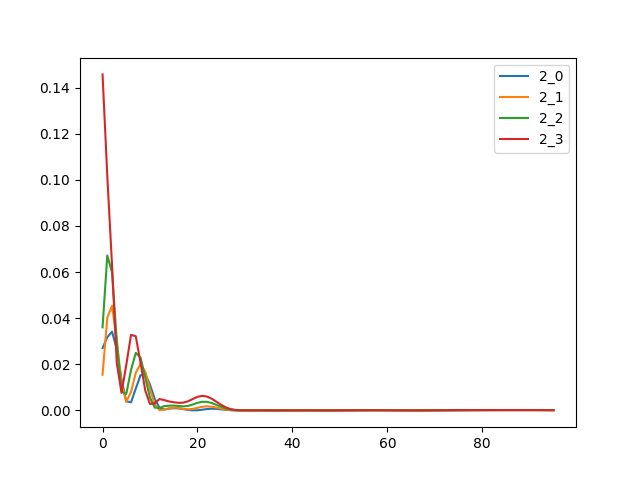

In [74]:
print('slice1 shape', slice1.shape)
print('XX shape', XX.shape)
print('ZZ shape', ZZ.shape)
print('slice2 shape', slice2.shape)
plt.figure()
plt.plot(slice2.T[:,0])
plt.plot(slice2.T[:,1])
plt.plot(slice2.T[:,2])
plt.plot(slice2.T[:,3])

plt.legend(['2_0','2_1','2_2','2_3'])
plt.show()